In [1]:
import math, pickle, os, copy, sys, scipy.io
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import random
import matplotlib.pyplot as plt

PROJECT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.insert(1, PROJECT_DIR)

from utils_pv import *
from feature_selection import tune_pacf, rfecv_selection
from samples.data_sim import remove_feature

random_seed = 3
random.seed(random_seed)
np.random.seed(random_seed)
random_state = np.random.RandomState(random_seed)


In [2]:
exp_name = 'PV_UniModal'
filename_env = os.getcwd() + "/../../saved_results/" + exp_name + "_nicolas_env_raw" # TODO
file = open(filename_env, 'rb')
print(filename_env)
env_dict = pickle.load(file)
msg = '[INFO] loaded data for {:2.0f} clients'.format(env_dict['num_clients'])
print(msg)
file.close()
print('\n'+env_dict['info'])

for scenario_name in env_dict['train_scenarios'].keys():
    print(scenario_name + ' has {:3.0f} train and {:3.0f} validation samples'.format(
                    env_dict['train_scenarios'][scenario_name]['clients_data'][0][0].shape[0],
                    env_dict['train_scenarios'][scenario_name]['clients_data'][0][2].shape[0]))
print('number of features = {:2.0f}'.format(
                    env_dict['train_scenarios'][scenario_name]['clients_data'][0][0].shape[1]))

/Users/mahrokh/DECODE/Simulations/Synthetic_PV_Profiles/samples/PV/../../saved_results/PV_UniModal_nicolas_env_raw
[INFO] loaded data for 24 clients

24 households at Lausanne - tilt_std: 5.0, az_std: 15.0, weather_dev: 0.1, irrad_std: 0.2, altitude_dev: 0.1, shadow_peak_red: 1.0, same module_name, same inverter_name, 
sml has 150 train and 140 validation samples
1y has 610 train and 140 validation samples
5y has 3050 train and 140 validation samples
number of features =  9


### 1. Selecting a subset of weather info and temporal information 
* run on a subset of clients to reduce computations
* analysis based on 5 years data 

In [3]:
# reconstruct houses
from house_pv import reconstruct_house
scenario_name_recons='5y'
clients_subset = [12, 14, 15, 17, 22]
houses = [None] * env_dict['num_clients']
for client_num in clients_subset:
    houses[client_num] = reconstruct_house(
                            env_dict=env_dict, 
                            client_num=client_num, 
                            scenario_name=scenario_name_recons)
print('[INFO] reconstructed the ' + scenario_name_recons + ' scenario.')


[INFO] reconstructed the 5y scenario.


check correlation between features

[RES] observations:
H_sun and hourofd_y are highly correlated (|corr|=0.79)
H_sun and station_irrad_direct_prev are slightly correlated (|corr|=0.68)
H_sun and station_irrad_diffuse_prev are highly correlated (|corr|=0.84)
T2m and dayofy_y are slightly correlated (|corr|=0.67)
hourofd_y and station_irrad_direct_prev are slightly correlated (|corr|=0.52)
hourofd_y and station_irrad_diffuse_prev are slightly correlated (|corr|=0.74)
station_irrad_direct_prev and station_irrad_diffuse_prev are slightly correlated (|corr|=0.52)


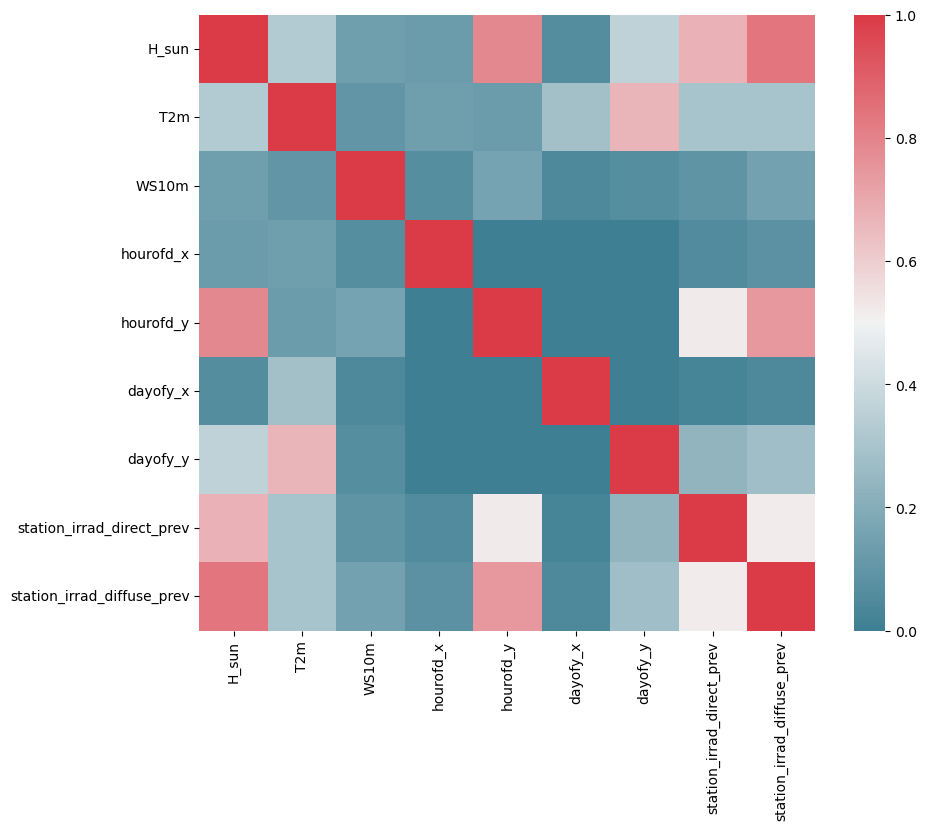

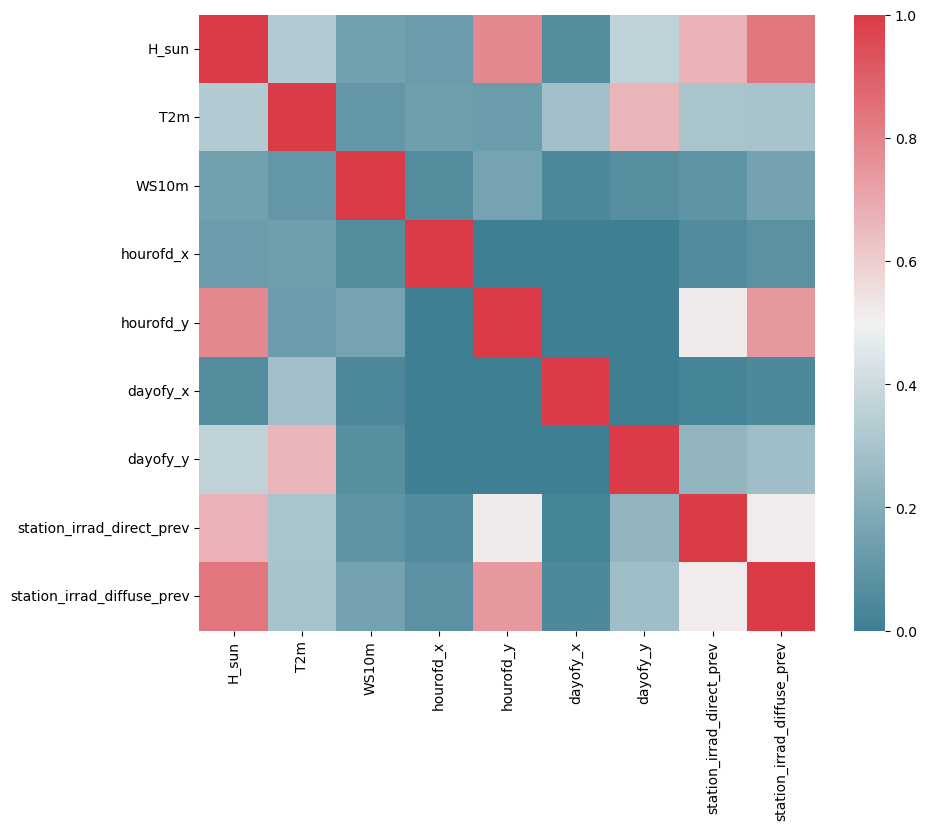

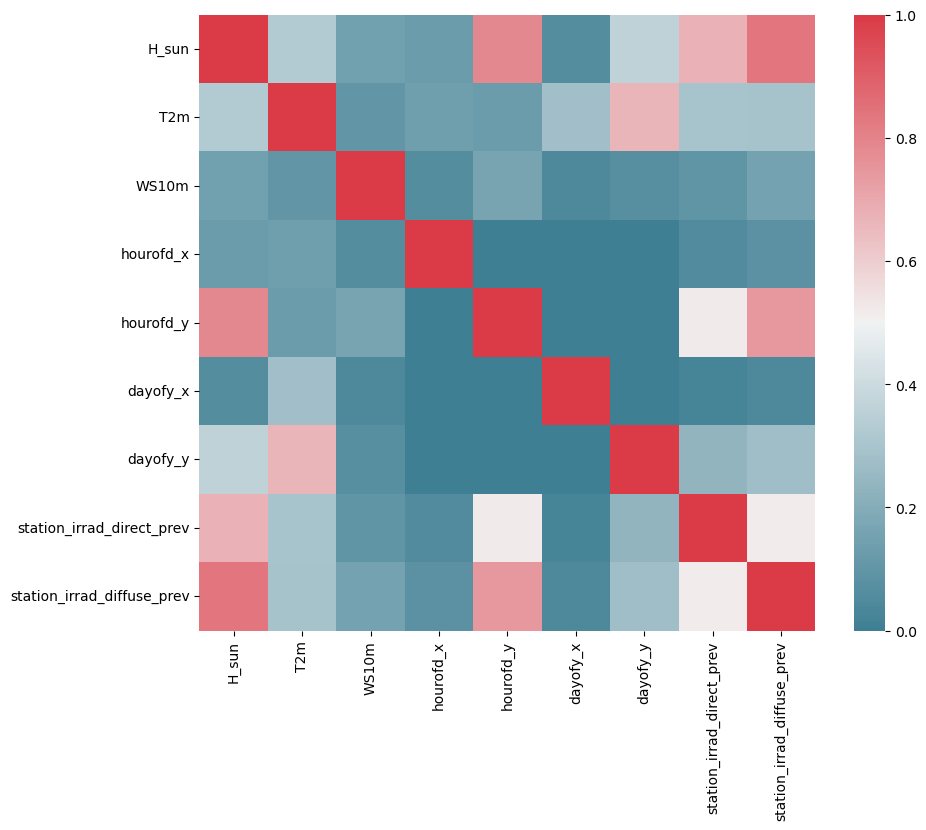

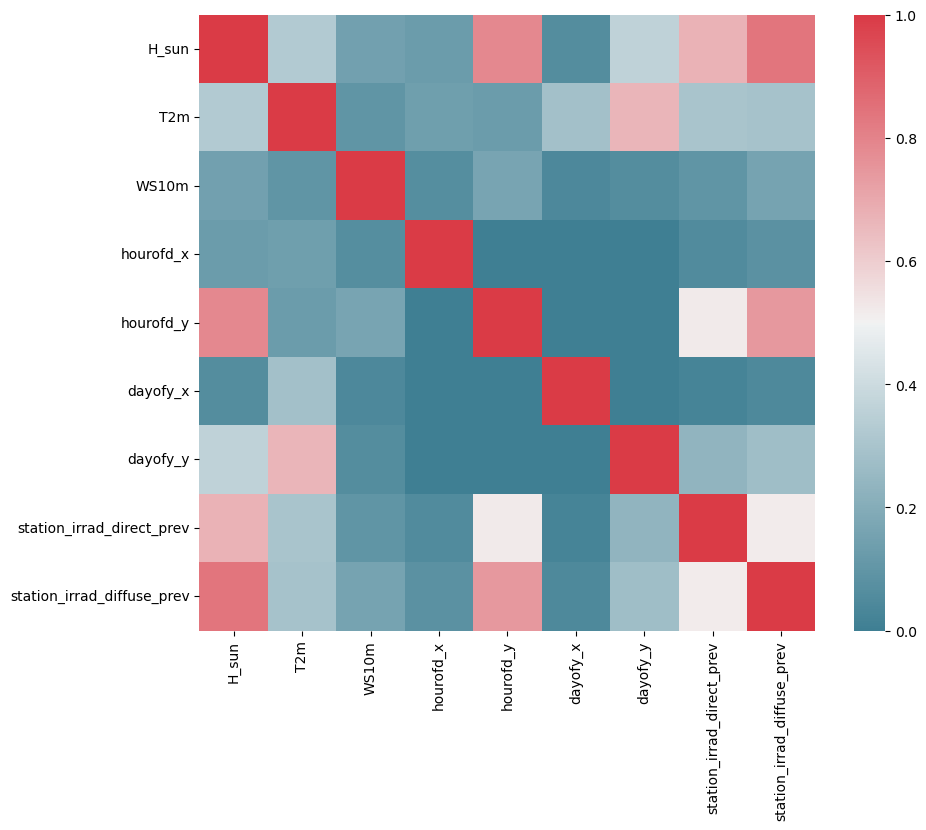

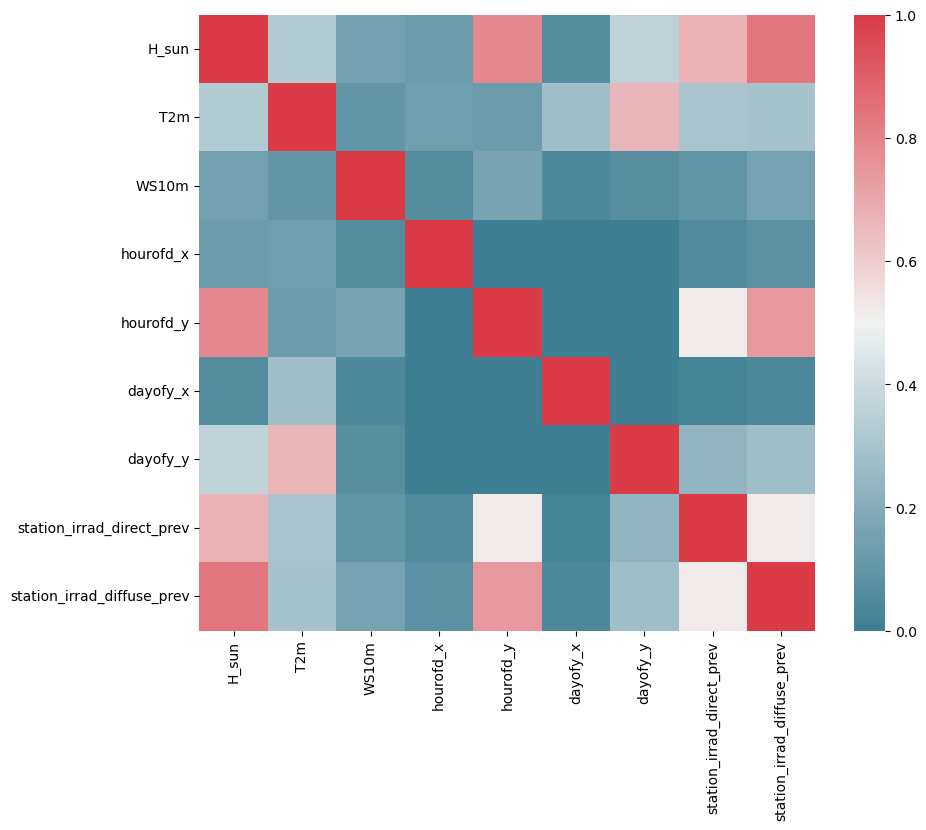

In [4]:
# correlation map between features
non_ar_feat_names = [x for x in env_dict['feature_names'] if not x.startswith('lag')]
corr_av = np.zeros((len(non_ar_feat_names), len(non_ar_feat_names)))
for client_num in clients_subset:
    # run correlation matrix and plot
    f, ax = plt.subplots(figsize=(10, 8))
    corr = houses[client_num].data_power.loc[:, non_ar_feat_names].corr()
    corr_av += np.abs(corr)
    sns.heatmap(np.abs(corr), mask=np.zeros_like(corr, dtype=bool),
                cmap=sns.diverging_palette(220, 10, as_cmap=True),
                square=True, ax=ax)
corr_av = corr_av/len(clients_subset)

msg = '[RES] observations:'
for row_ind, row in enumerate(corr_av.index):
    for col_ind, col in enumerate(corr_av.columns):
        if row_ind<col_ind:
            if np.abs(corr_av.iloc[row_ind, col_ind])>=0.75:
                msg += '\n' + row + ' and ' + col + ' are highly correlated (|corr|={:0.2f})'.format(np.abs(corr_av.iloc[row_ind, col_ind]))
            elif np.abs(corr_av.iloc[row_ind, col_ind])>=0.5:
                msg += '\n' + row + ' and ' + col + ' are slightly correlated (|corr|={:0.2f})'.format(np.abs(corr_av.iloc[row_ind, col_ind]))
print(msg)



In [5]:
# correlation with the power
non_ar_feat_names = [x for x in env_dict['feature_names'] if not x.startswith('lag')]
corr_out = pd.DataFrame(columns = ['Client '+str(client_num) for client_num in clients_subset])
for client_num in clients_subset:    
    corr_out.loc[:, 'Client '+str(client_num)] = houses[client_num].data_power.loc[:, non_ar_feat_names].corrwith(houses[client_num].data_power.loc[:, 'target'])
corr_out['Average'] = corr_out.mean(numeric_only=True, axis=1)
print(corr_out)


msg = '\n[RES] observations:'
for feature in corr_out.index:
    corr_feat = corr_out.loc[feature, 'Average']
    if np.abs(corr_feat)<0.05:
        msg += '\ncorrelation of ' + feature + ' with the output is very low'
print(msg)

                            Client 12  Client 14  Client 15  Client 17  \
H_sun                        0.861097   0.863260   0.867637   0.871614   
T2m                          0.260729   0.283537   0.272573   0.285028   
WS10m                        0.100201   0.121941   0.111428   0.118410   
hourofd_x                    0.153892   0.066432   0.118494   0.090413   
hourofd_y                   -0.672973  -0.686896  -0.679188  -0.682965   
dayofy_x                     0.041960   0.040689   0.042500   0.043266   
dayofy_y                    -0.253741  -0.257936  -0.261215  -0.269729   
station_irrad_direct_prev    0.807202   0.872321   0.840792   0.859937   
station_irrad_diffuse_prev   0.710215   0.741284   0.725584   0.737775   

                            Client 22   Average  
H_sun                        0.857392  0.864200  
T2m                          0.256536  0.271681  
WS10m                        0.103873  0.111171  
hourofd_x                    0.153641  0.116574  
hourofd_y

remove features that are correlated with each other or have a low correlation with the output

['H_sun', 'T2m', 'WS10m', 'hourofd_x', 'dayofy_y', 'station_irrad_direct_prev']


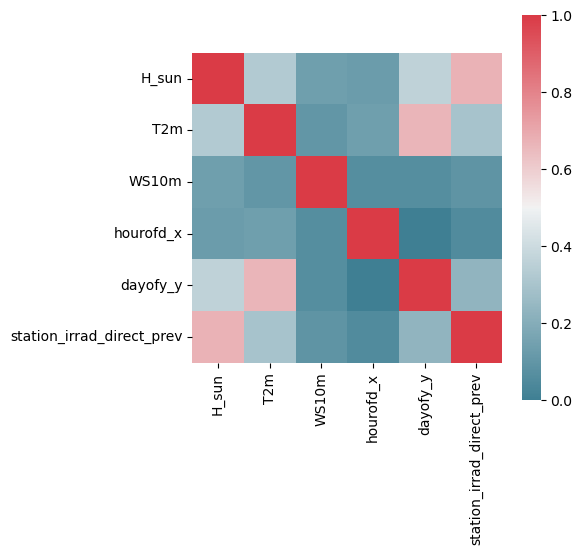

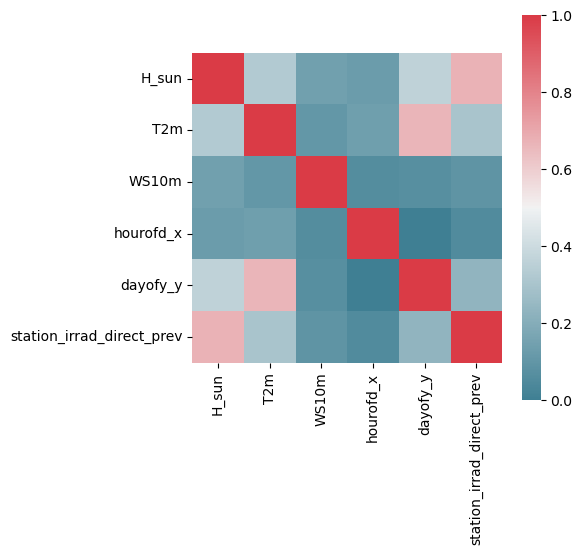

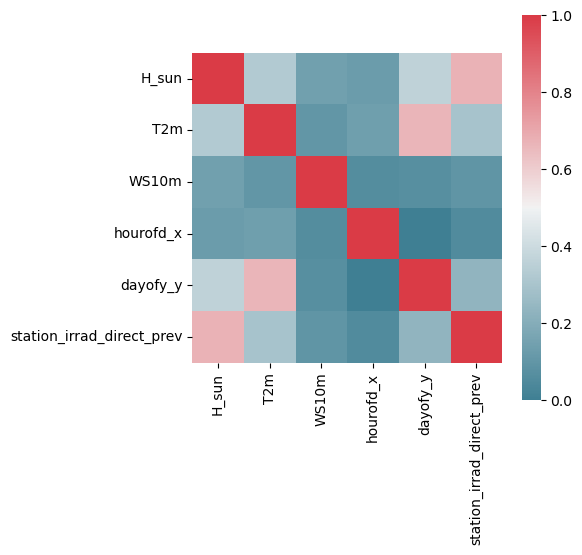

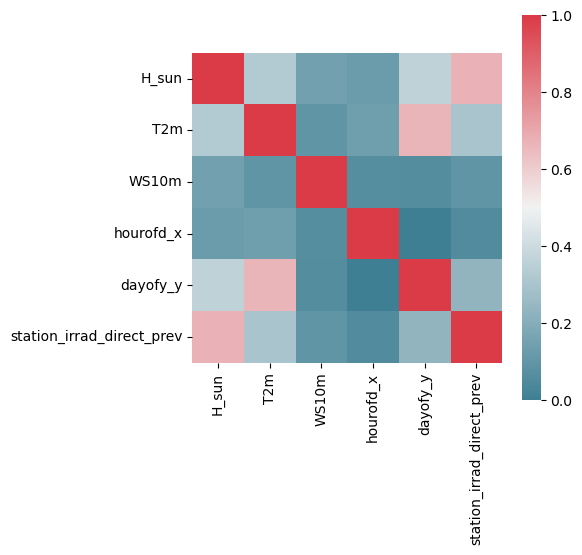

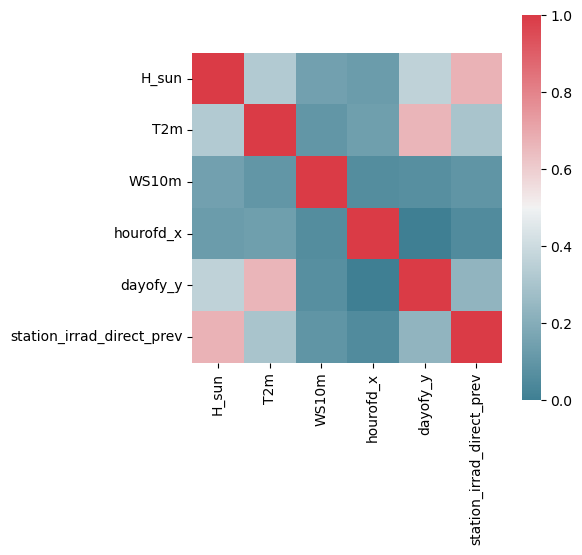

In [6]:
non_ar_feat_remove = ['hourofd_y', 'station_irrad_diffuse_prev', 'dayofy_x']
for feature_name in non_ar_feat_remove:
    remove_feature(
        env_dict=env_dict, 
        feature_name=feature_name, in_place=True)
    for house in houses:
        if not house is None:
            house.feature_names.remove(feature_name)

print(env_dict['feature_names'])
non_ar_feat_names = [x for x in env_dict['feature_names'] if not x.startswith('lag')]
for client_num in clients_subset:
    # run correlation matrix and plot
    f, ax = plt.subplots(figsize=(5, 5))
    corr = houses[client_num].data_power.loc[:, non_ar_feat_names].corr()
    sns.heatmap(np.abs(corr), mask=np.zeros_like(corr, dtype=bool),
                cmap=sns.diverging_palette(220, 10, as_cmap=True),
                square=True, ax=ax)


# Selecting Features with RFECV
using a Ridge model with tuned penalty every time and Adj R2 scorer


[INFO] the following 48 constnat features were removed:  lag 12 lag 36 lag 60 lag 84 lag 108 lag 132 lag 156 lag 180 lag 204 lag 205 lag 228 lag 229 lag 252 lag 253 lag 276 lag 277 lag 300 lag 301 lag 324 lag 325 lag 348 lag 349 lag 372 lag 373 lag 396 lag 397 lag 420 lag 421 lag 444 lag 445 lag 467 lag 468 lag 469 lag 491 lag 492 lag 493 lag 515 lag 516 lag 517 lag 539 lag 540 lag 541 lag 563 lag 564 lag 565 lag 587 lag 588 lag 589
[INFO] searching among 558 features
[INFO] the following 24 features were selected:
H_sun station_irrad_direct_prev lag 1 lag 4 lag 19 lag 23 lag 29 lag 30 lag 575


/opt/anaconda3/envs/py3.9.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


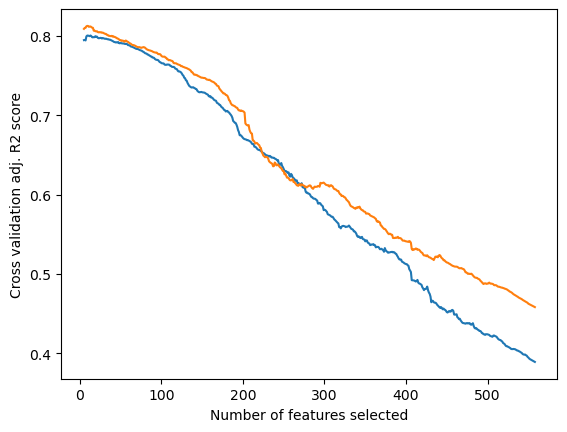

[INFO] the following 48 constnat features were removed:  lag 12 lag 36 lag 60 lag 84 lag 108 lag 132 lag 156 lag 180 lag 204 lag 205 lag 228 lag 229 lag 252 lag 253 lag 276 lag 277 lag 300 lag 301 lag 324 lag 325 lag 348 lag 349 lag 372 lag 373 lag 396 lag 397 lag 420 lag 421 lag 444 lag 445 lag 467 lag 468 lag 469 lag 491 lag 492 lag 493 lag 515 lag 516 lag 517 lag 539 lag 540 lag 541 lag 563 lag 564 lag 565 lag 587 lag 588 lag 589
[INFO] searching among 558 features
[INFO] the following 24 features were selected:
H_sun hourofd_x dayofy_y station_irrad_direct_prev lag 1 lag 2 lag 4 lag 23 lag 28 lag 30 lag 220 lag 222


/opt/anaconda3/envs/py3.9.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


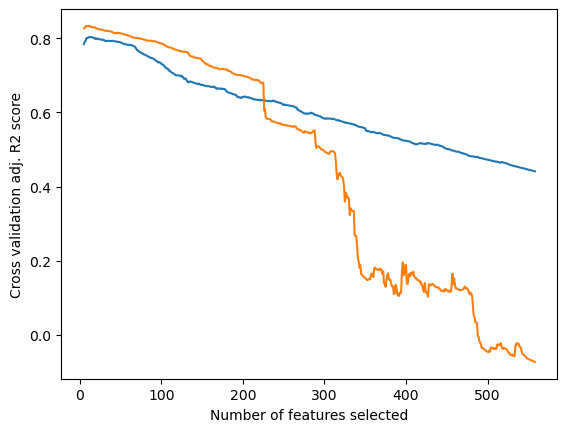

[INFO] the following 48 constnat features were removed:  lag 12 lag 36 lag 60 lag 84 lag 108 lag 132 lag 156 lag 180 lag 204 lag 205 lag 228 lag 229 lag 252 lag 253 lag 276 lag 277 lag 300 lag 301 lag 324 lag 325 lag 348 lag 349 lag 372 lag 373 lag 396 lag 397 lag 420 lag 421 lag 444 lag 445 lag 467 lag 468 lag 469 lag 491 lag 492 lag 493 lag 515 lag 516 lag 517 lag 539 lag 540 lag 541 lag 563 lag 564 lag 565 lag 587 lag 588 lag 589
[INFO] searching among 558 features


In [7]:
from sklearn.feature_selection import RFECV
from model_training.search_models import RidgeWrapper
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Ridge
from house_pv import _augment_lags, remove_constant_cols


def adj_r2_scorer(estimator, X, y):
    y = y.flatten()
    y_pred = estimator.predict(X).flatten()
    R2 = r2_score(y, y_pred)
    n, p = X.shape
    return 1-(1-R2)*(n-1)/(n-p-1)

run_cell = True
if run_cell:
    # params
    cv = 2
    plot_fig = True
    days_look_back = 25
    keep_non_ar = False # forcee all non-ar features to remain
    min_features_to_select = 5

    # init
    selected_features = [None] * env_dict['num_clients']
    scenario = env_dict['train_scenarios'][scenario_name_recons]

    # all lags to try
    full_lags = np.arange(1, 
                    min(
                        24*days_look_back+1, 
                        math.floor(env_dict['train_scenarios'][scenario_name_recons]['clients_data'][0][0].shape[0]/cv)-1))
    full_lag_names = ['lag ' + str(x) for x in full_lags]

    # search
    for client_num in clients_subset:
        house = houses[client_num]
        # augment lags
        house.data_power = _augment_lags(
                                house.data_power, 
                                lags=full_lags, 
                                step_ahead=1)
        house.feature_names += full_lag_names
        for x in non_ar_feat_remove:
            assert not x in house.feature_names

        # construct regression matrices
        data_tuple = house.construct_regression_matrices(
                                m_train=scenario['m_train'],
                                train_years=scenario['train_years'],
                                exclude_last_year=scenario['exclude_last_year'])

        # remove constant lags
        house.data_power, data_tuple, house.feature_names = remove_constant_cols(
                                data_power=house.data_power, 
                                data_tuple=data_tuple, 
                                feature_names=house.feature_names)
        print('[INFO] searching among {:2.0f} features'.format(len(house.feature_names)))
        
        # fit Ridge regression with Grid search over penalty
        ridge_wrapper = RidgeWrapper(alphas=np.logspace(-6,2,20)) 
        
        # fit RFECV
        X_train, y_train, X_valid, y_valid = data_tuple
        selector = RFECV(
                    estimator=ridge_wrapper, step=1, cv=cv, 
                    scoring=adj_r2_scorer, 
                    min_features_to_select=min_features_to_select) 
        selector = selector.fit(X_train, y_train.flatten())
        
        #Force every non-lag feature to be in the RFECV
        if keep_non_ar:
            for i, feature_name in enumerate(house.feature_names):
                if not feature_name.startswith('lag'):
                    selector.support_[i] = True
                    
        selected_features[client_num] = [house.feature_names[i] for i, x in enumerate(selector.support_) if x]
        print('[INFO] the following {:2.0f} features were selected:'.format(len(selected_features)))
        print(*selected_features[client_num])

        # Plot number of features VS. cross-validation scores
        if plot_fig:
            plt.figure()
            plt.xlabel("Number of features selected")
            plt.ylabel("Cross validation adj. R2 score")
            plt.plot(range(min_features_to_select,
                            len(selector.grid_scores_) + min_features_to_select),
                        selector.grid_scores_)
            plt.show()


    # save
    file = open(os.getcwd() + "/../../saved_results/" + exp_name + "_feat_eng", 'wb')
    pickle.dump(
        {'selected_features':selected_features}, 
        file)
# load
else:
    file = open(os.getcwd() + "/../../saved_results/" + exp_name + "_feat_eng", 'rb')
    res = pickle.load(file)
    print(res.keys())
    selected_features = res['selected_features']
file.close()



Check which hours in the previous days were important

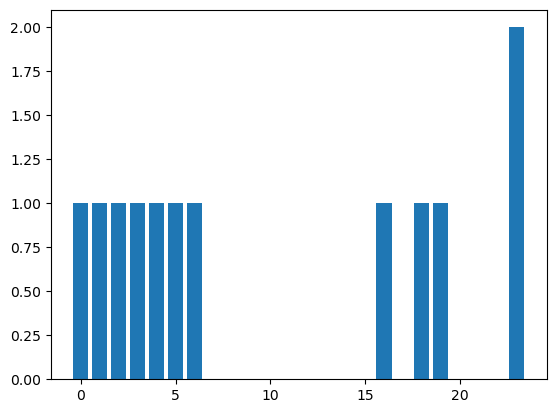

In [ ]:
for client_num in clients_subset:
    if not selected_features[client_num] is None:
        lag_nums = [int(x.split()[-1]) for x in selected_features[client_num] if x.startswith('lag')]
        lag_nums_mod = [x%24 for x in lag_nums]
        counts = [lag_nums_mod.count(x) for x in np.arange(24)]

        plt.bar(np.arange(24), counts)

Identify important features

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

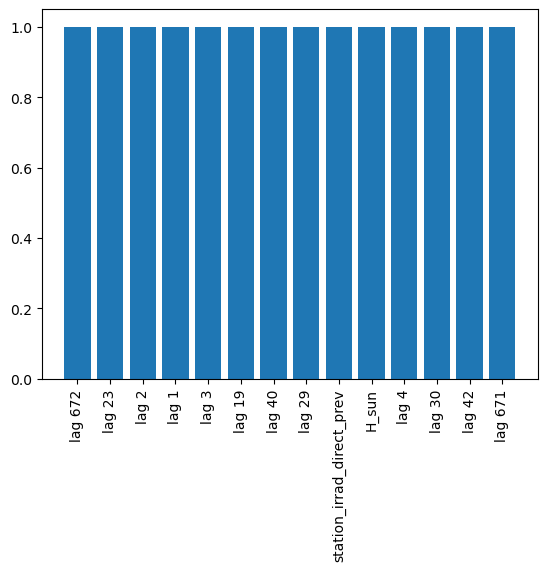

In [ ]:
# analyze regressors
all_counts = []
for client_num in clients_subset:
    if not selected_features[client_num] is None:
        all_counts.extend([x for x in selected_features[client_num]])
counts = [all_counts.count(x) for x in set(all_counts)]
plt.bar(list(set(all_counts)), counts)
plt.xticks(rotation=90)

### Feature Selection using PACF

[INFO] the following constnat features were removed:  lag 12 lag 180 lag 108 lag 467 lag 228 lag 252 lag 587 lag 611 lag 348 lag 373 lag 325 lag 156 lag 60 lag 563 lag 516 lag 301 lag 84 lag 492 lag 276 lag 253 lag 132 lag 204 lag 420 lag 539 lag 684 lag 564 lag 277 lag 349 lag 659 lag 324 lag 372 lag 683 lag 565 lag 468 lag 515 lag 708 lag 636 lag 396 lag 589 lag 661 lag 660 lag 540 lag 300 lag 444 lag 397 lag 421 lag 612 lag 469 lag 491 lag 613 lag 445 lag 707 lag 685 lag 493 lag 709 lag 541 lag 635 lag 517 lag 36 lag 588 lag 637
[INFO] sorted lags after removing constant lags during training:  1 2 3 20 19 21 18 22 17 4 23 10 25 45 9 46 44 11 69 70 47 68 16 43 8 49 26 93 13 118 73 94 71 67 117 27 116 142 166 95 92 167 190 50 97 165 141 14 214 145 121 143 42 189 91 169 140 74 119 213 262 66 164 115 51 48 188 139 337 163 237 6 217 383 72 265 144 478 287 191 285 40 260 433 239 211 212 406 238 479 575 34 236 215 284 122 286 261 33 481 193 98 30 476 114 380 90 670 259 359 431 381 308 457 

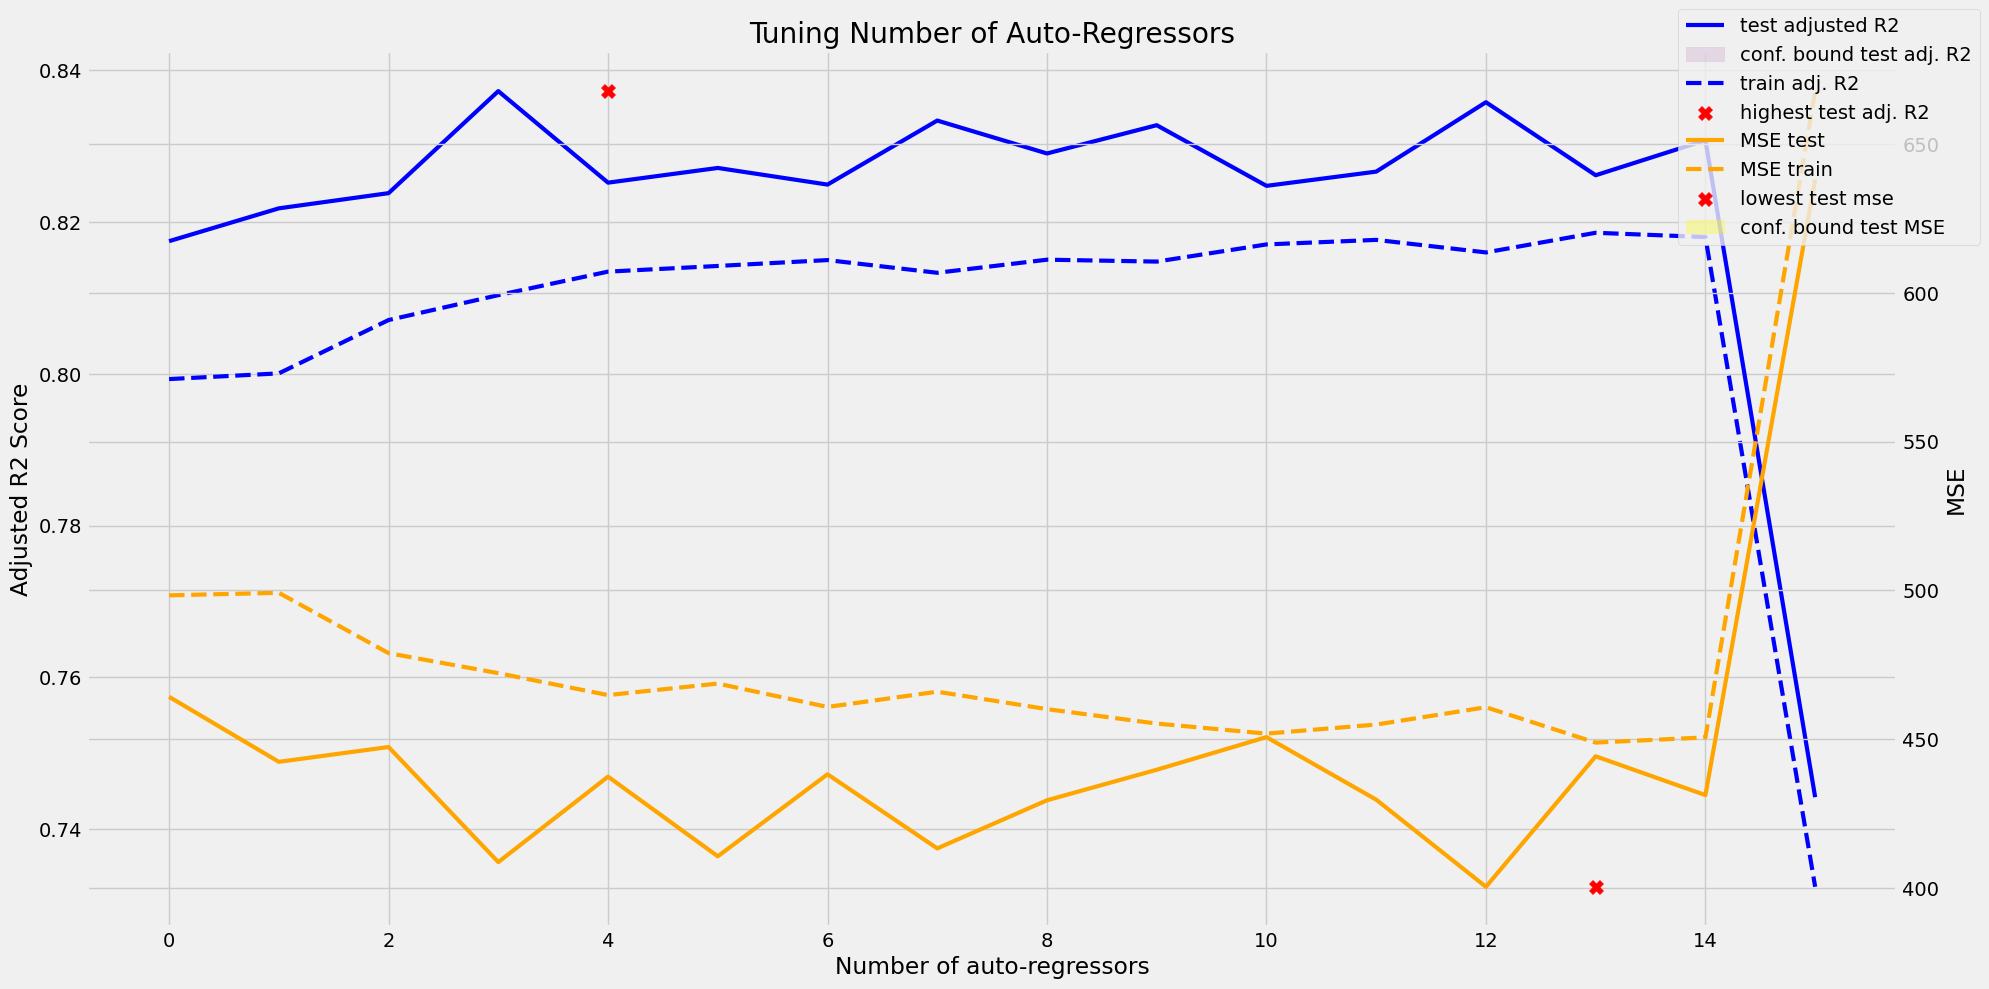

Results:
Criterion			Num.auto-regressors		Adj. R2 test		AIC test	MSE test
-------------------------------------------------------------------------------------------------------------
max adj. R2:			4				0.8372			-7.0480		408.7081
min MSE:			13				0.8358			10.9931		400.4127
first in range:			4				0.8372			-7.0480		408.7081
-------------------------------------------------------------------------------------------------------------
[RES] lags by first in range:  1 2 3 20
[RES] lags by lowest adj r2:  1 2 3 20
(139535, 673)
[INFO] the following constnat features were removed:  lag 12 lag 467 lag 563 lag 587 lag 325 lag 301 lag 180 lag 611 lag 491 lag 36 lag 707 lag 469 lag 277 lag 373 lag 349 lag 492 lag 253 lag 683 lag 539 lag 420 lag 659 lag 515 lag 516 lag 421 lag 132 lag 108 lag 252 lag 468 lag 84 lag 635 lag 60 lag 637 lag 228 lag 276 lag 564 lag 636 lag 156 lag 348 lag 397 lag 684 lag 517 lag 493 lag 709 lag 661 lag 444 lag 324 lag 708 lag 613 lag 589 lag 541 lag 565 lag 372 lag 61

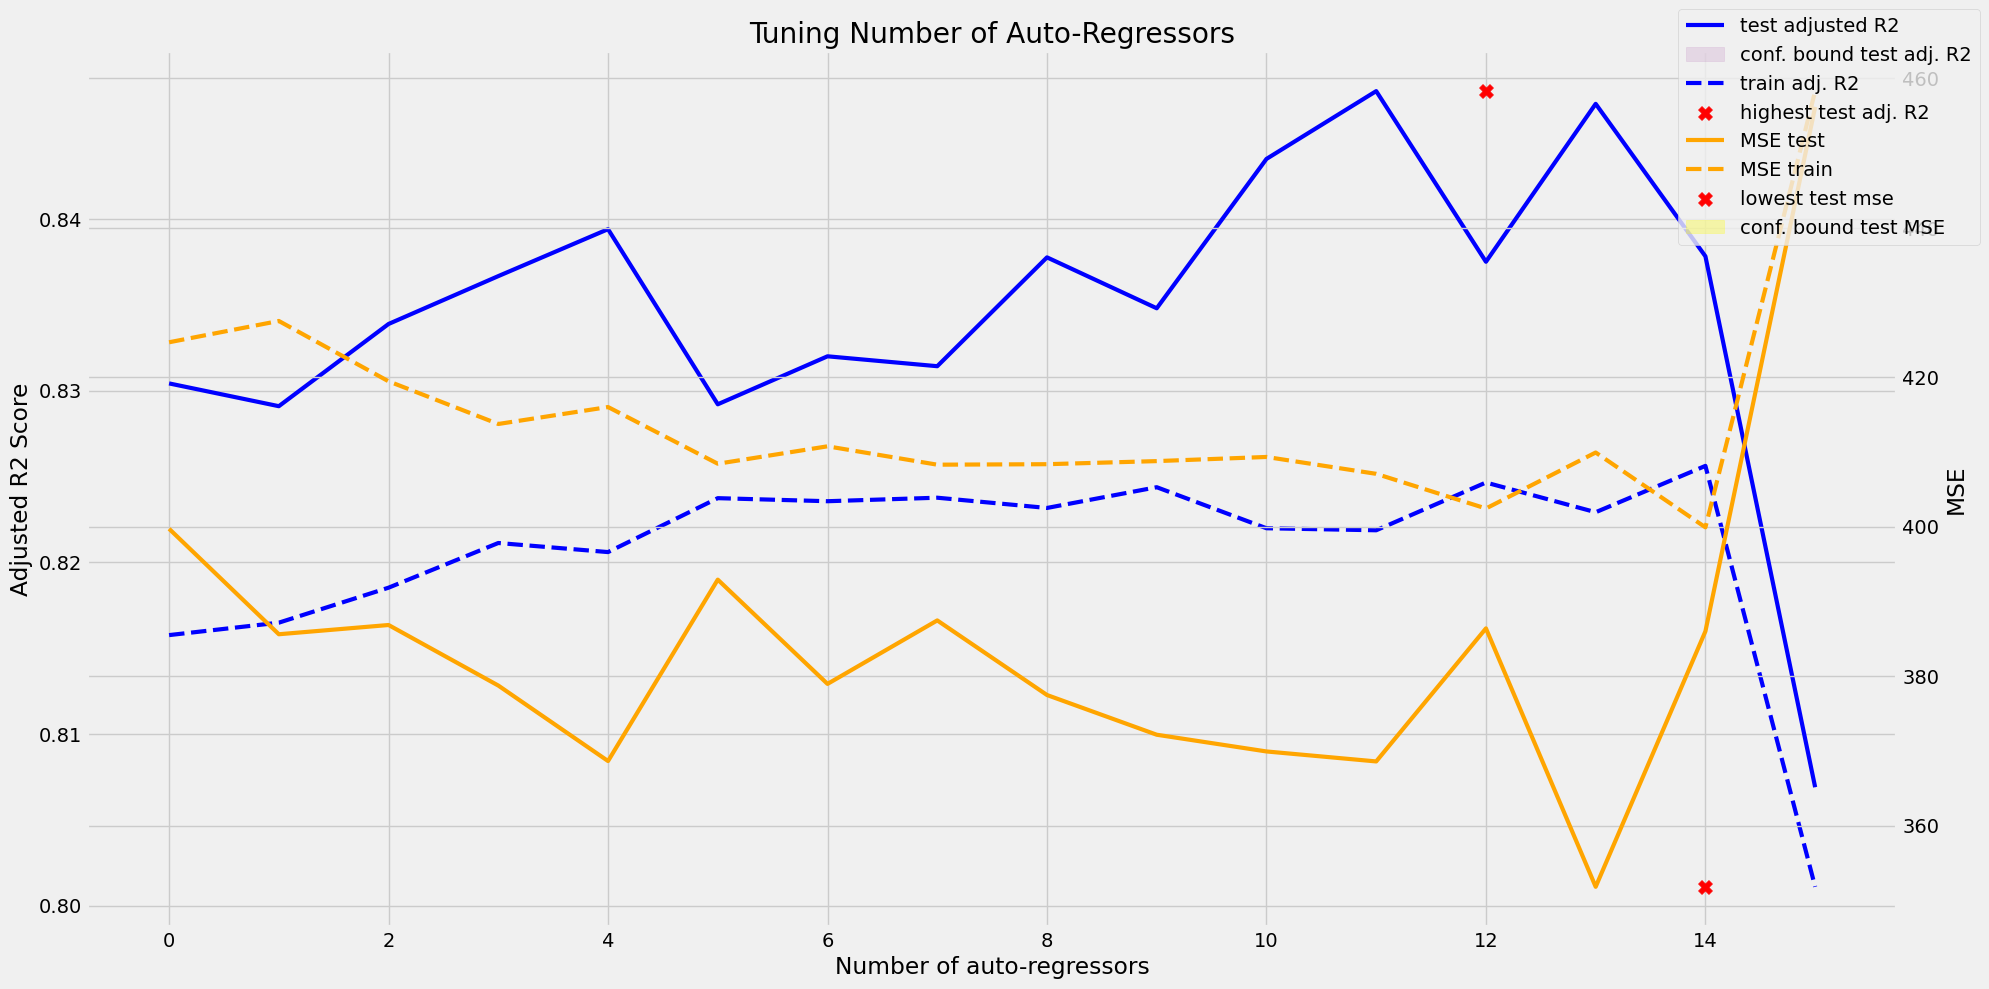

Results:
Criterion			Num.auto-regressors		Adj. R2 test		AIC test	MSE test
-------------------------------------------------------------------------------------------------------------
max adj. R2:			12				0.8474			9.1565		368.5925
min MSE:			14				0.8467			13.2496		351.8175
first in range:			2				0.8291			-10.9338		385.6112
-------------------------------------------------------------------------------------------------------------
[RES] lags by first in range:  1 2
[RES] lags by lowest adj r2:  1 2 3 20 19 21 18 22 17 4 23 10
(140255, 16)
[INFO] the following constnat features were removed:  lag 12 lag 180 lag 611 lag 36 lag 467 lag 563 lag 587 lag 539 lag 252 lag 108 lag 228 lag 492 lag 516 lag 325 lag 132 lag 420 lag 276 lag 373 lag 301 lag 636 lag 684 lag 348 lag 156 lag 564 lag 349 lag 659 lag 60 lag 683 lag 707 lag 84 lag 515 lag 277 lag 204 lag 468 lag 491 lag 253 lag 708 lag 660 lag 469 lag 324 lag 540 lag 372 lag 421 lag 661 lag 635 lag 612 lag 565 lag 444 lag 396 lag 589 lag 

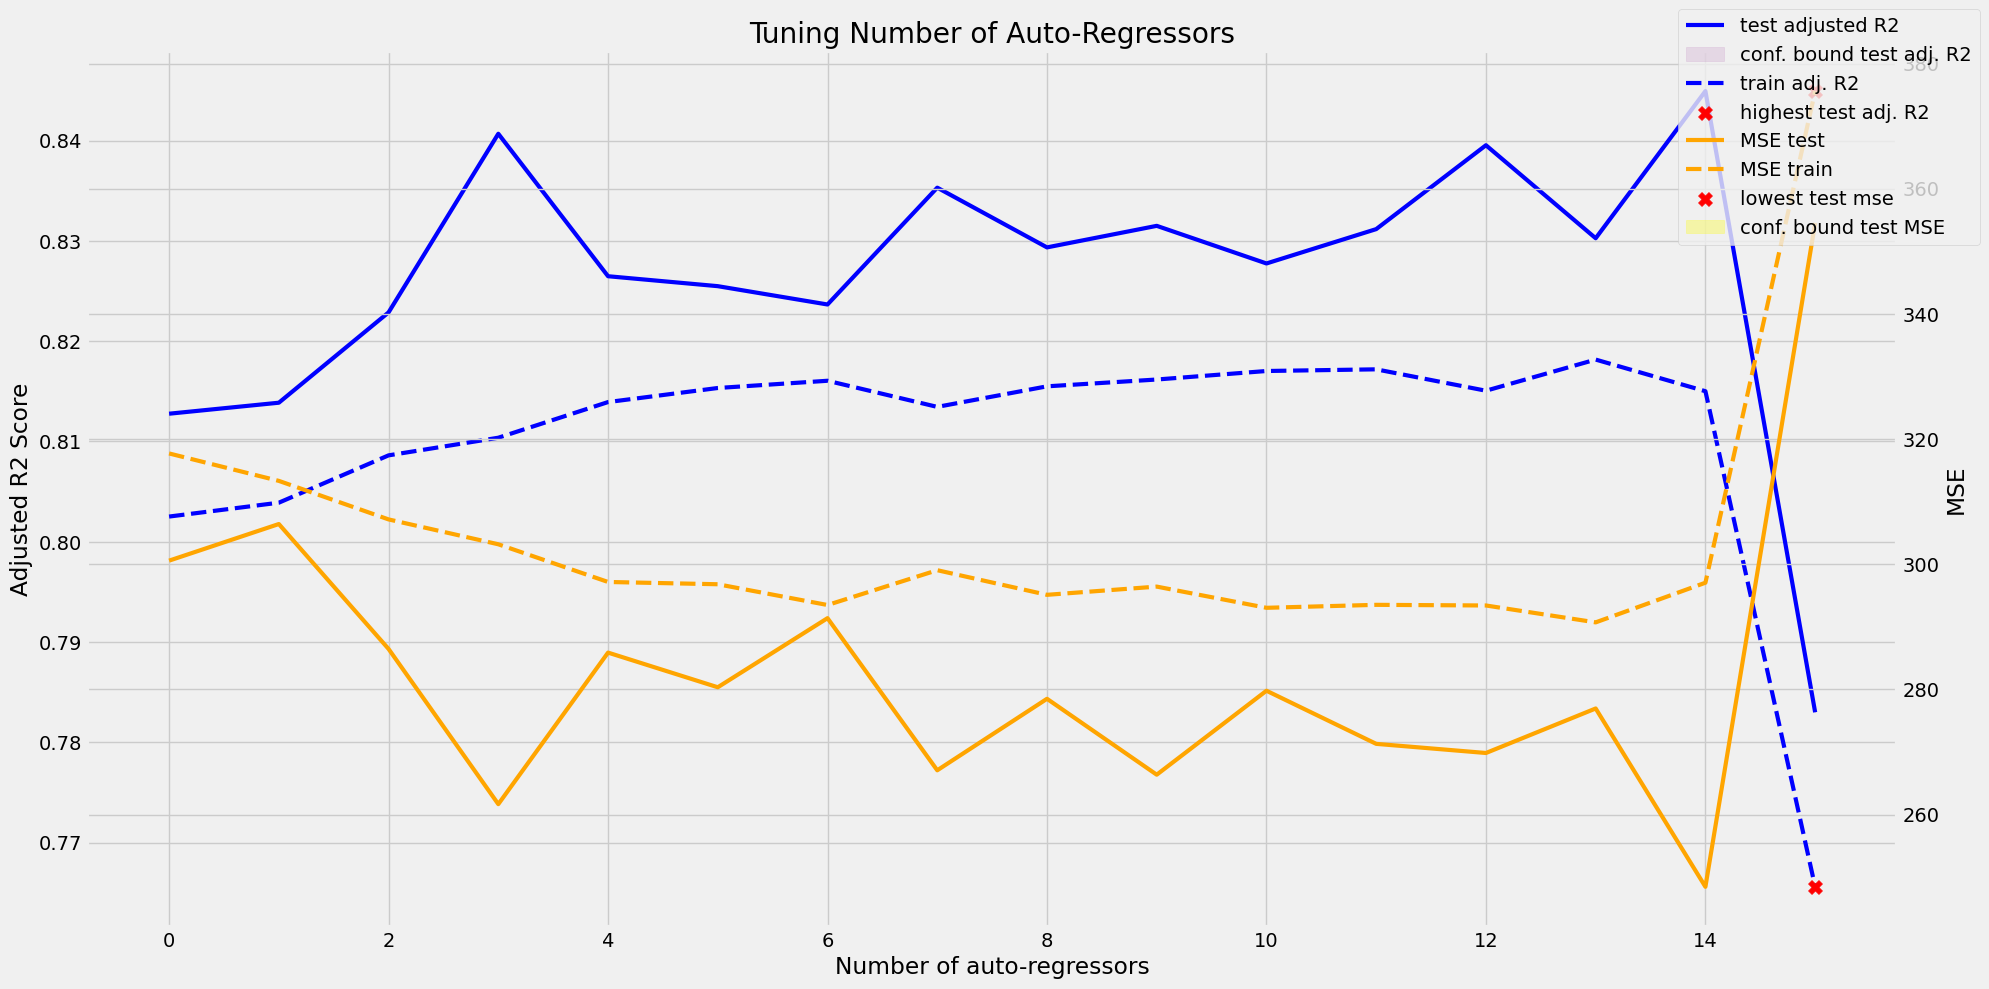

Results:
Criterion			Num.auto-regressors		Adj. R2 test		AIC test	MSE test
-------------------------------------------------------------------------------------------------------------
max adj. R2:			15				0.8449			15.9452		248.4702
min MSE:			15				0.8449			15.9452		248.4702
first in range:			4				0.8407			-6.1584		261.6753
-------------------------------------------------------------------------------------------------------------
[RES] lags by first in range:  1 2 3 20
[RES] lags by lowest adj r2:  1 2 3 20 19 21 18 22 17 4 23 10 45 9 25
(140255, 16)
[INFO] the following constnat features were removed:  lag 12 lag 36 lag 563 lag 467 lag 587 lag 180 lag 611 lag 539 lag 492 lag 707 lag 516 lag 325 lag 683 lag 252 lag 108 lag 132 lag 301 lag 659 lag 228 lag 420 lag 515 lag 491 lag 349 lag 276 lag 373 lag 636 lag 564 lag 684 lag 468 lag 348 lag 277 lag 84 lag 469 lag 156 lag 635 lag 421 lag 660 lag 708 lag 60 lag 253 lag 444 lag 540 lag 324 lag 204 lag 661 lag 709 lag 612 lag 517 lag 372

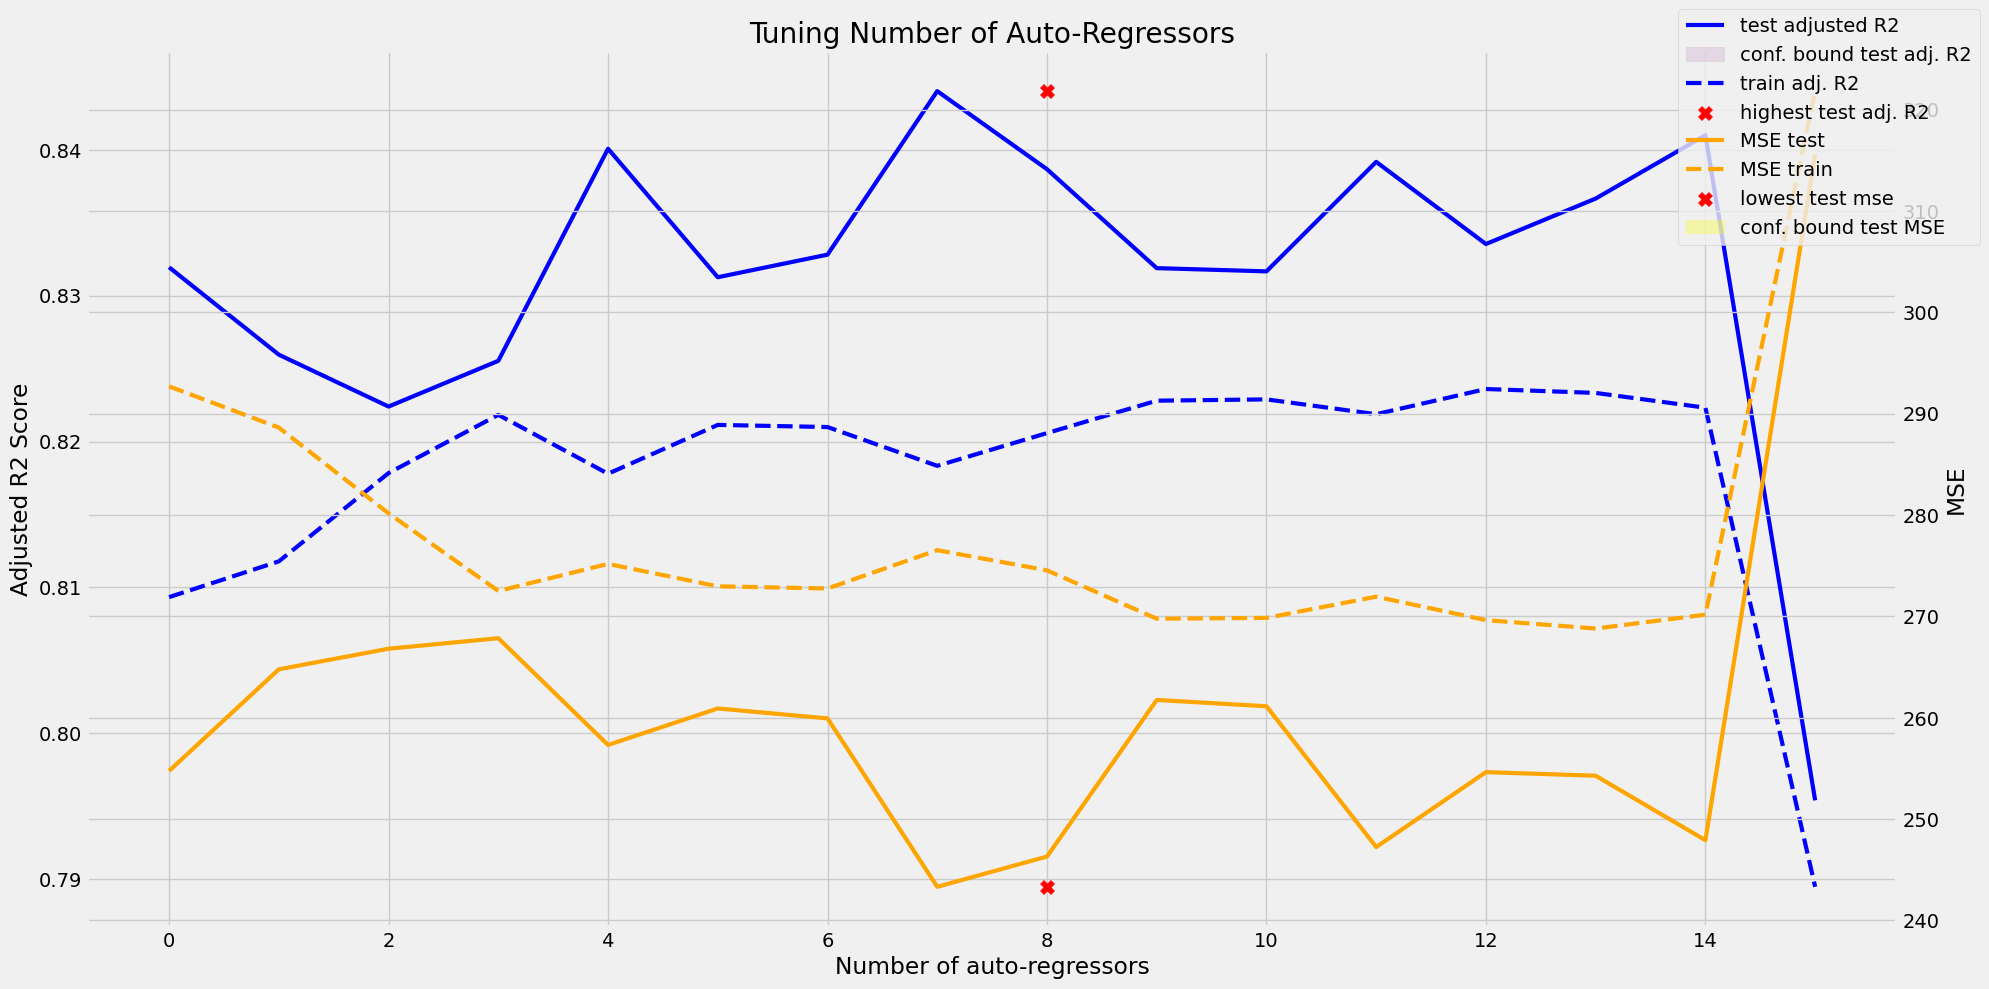

Results:
Criterion			Num.auto-regressors		Adj. R2 test		AIC test	MSE test
-------------------------------------------------------------------------------------------------------------
max adj. R2:			8				0.8440			1.9871		243.3230
min MSE:			8				0.8440			1.9871		243.3230
first in range:			1				0.8319			-12.1048		254.7559
-------------------------------------------------------------------------------------------------------------
[RES] lags by first in range:  1
[RES] lags by lowest adj r2:  1 2 3 20 19 21 18 22
(140255, 16)
[INFO] the following constnat features were removed:  lag 12 lag 180 lag 108 lag 467 lag 228 lag 252 lag 60 lag 587 lag 373 lag 84 lag 348 lag 276 lag 156 lag 204 lag 325 lag 132 lag 492 lag 563 lag 611 lag 301 lag 516 lag 253 lag 420 lag 539 lag 277 lag 372 lag 324 lag 349 lag 684 lag 564 lag 659 lag 468 lag 515 lag 565 lag 300 lag 683 lag 396 lag 636 lag 661 lag 589 lag 708 lag 444 lag 612 lag 540 lag 613 lag 469 lag 491 lag 397 lag 660 lag 421 lag 445 lag 541 lag

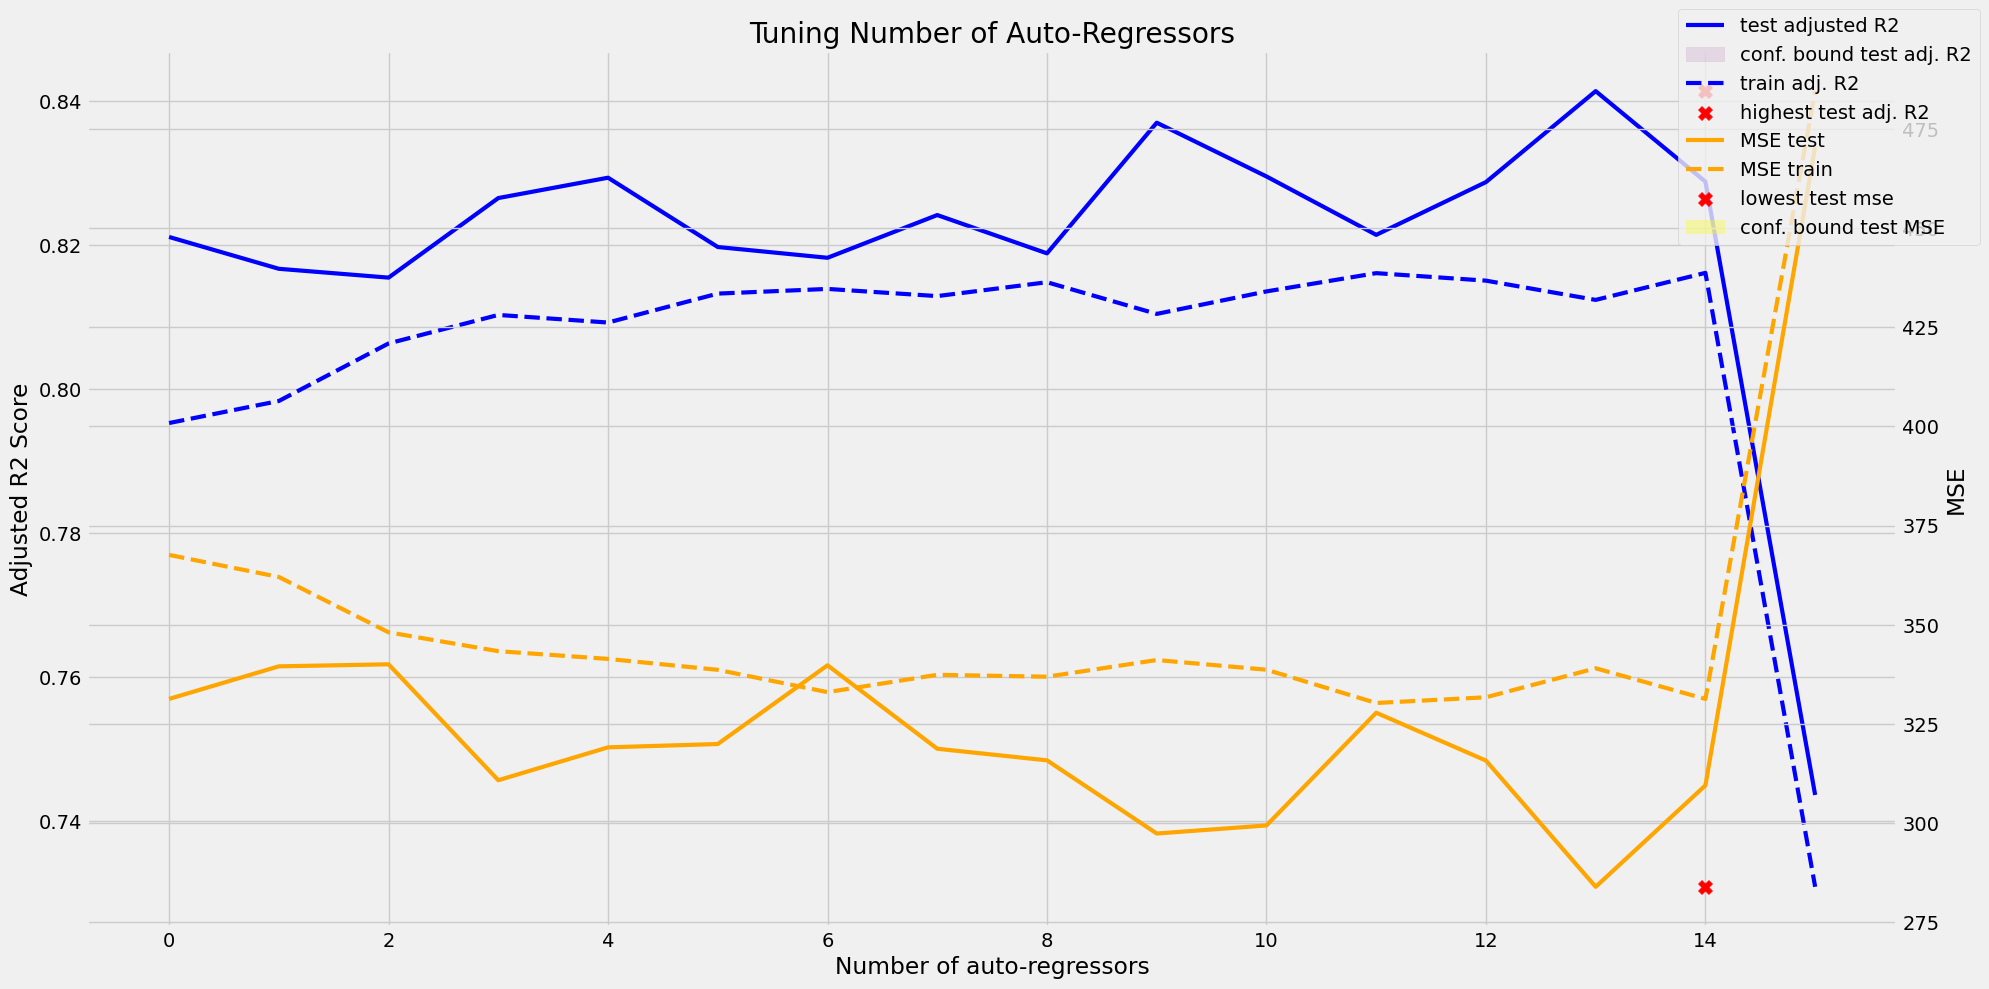

Results:
Criterion			Num.auto-regressors		Adj. R2 test		AIC test	MSE test
-------------------------------------------------------------------------------------------------------------
max adj. R2:			14				0.8414			13.6780		283.9912
min MSE:			14				0.8414			13.6780		283.9912
first in range:			4				0.8265			-6.5027		310.8455
-------------------------------------------------------------------------------------------------------------
[RES] lags by first in range:  1 2 3 20
[RES] lags by lowest adj r2:  1 2 3 20 19 21 18 22 17 23 4 25 10 45
(140255, 16)


In [ ]:
# selecting the lags
first_in_range, best_num_r = [None]*env_dict['num_clients'], [None]*env_dict['num_clients']
best_num_m, sorted_lags = [None]*env_dict['num_clients'], [None]*env_dict['num_clients']
for client_num in clients_subset:
    first_in_range[client_num], best_num_r[client_num], best_num_m[client_num], sorted_lags[client_num] = tune_pacf(
                    house=houses[client_num], max_num_lags=15, max_num_days=30,
                    step_ahead=1, repeats=1, verbose=True)
    print('[RES] lags by first in range: ', *sorted_lags[client_num][:first_in_range[client_num]])
    print('[RES] lags by lowest adj r2: ', *sorted_lags[client_num][:best_num_r[client_num]])
    print(houses[client_num].data_power.shape)


# Feature Selection Based on Several Houses

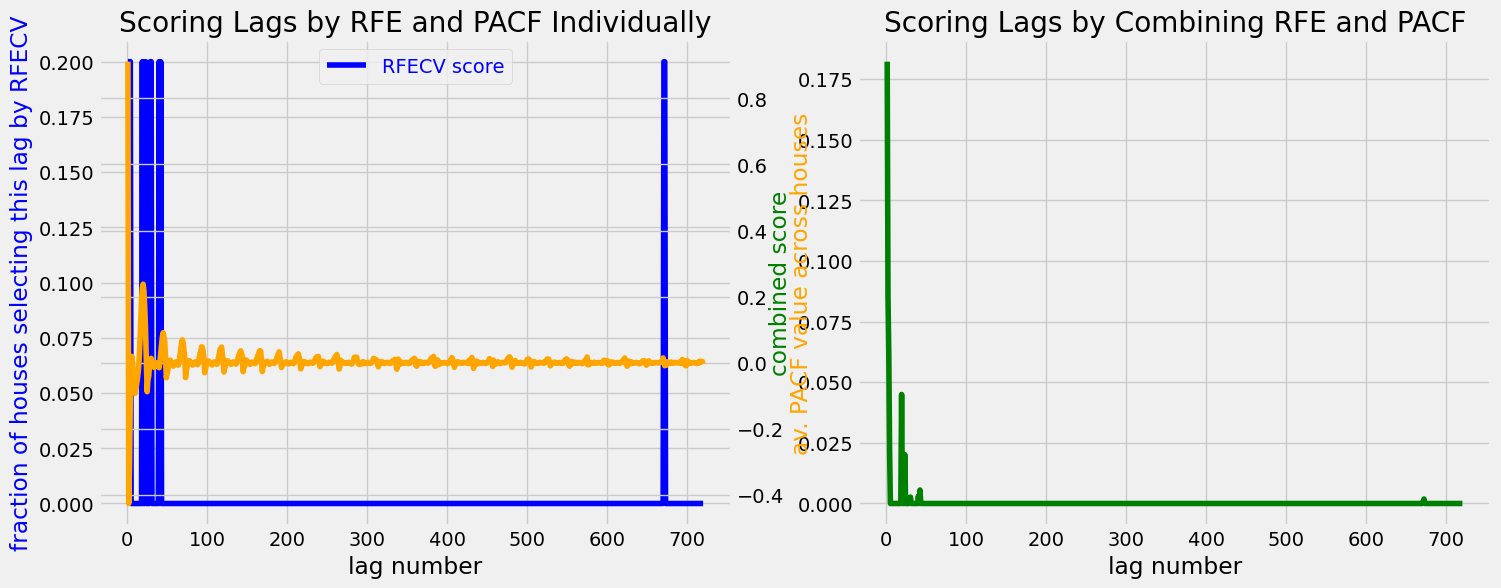

[INFO] sorted lags:  lag 1 lag 2 lag 3 lag 19 lag 4 lag 23 lag 42 lag 40 lag 30 lag 29 lag 672 lag 671


In [ ]:
import statsmodels.tsa.stattools as sttools
# analyze auto-regressors
# --- COMPUTE AV PACF SCORES ---
pacf_val = np.zeros(full_lags[-1]+1)
for client_num in clients_subset:
    powers = houses[client_num].data_power.loc[:, 'target'].values
    pacf_val += sttools.pacf(powers, nlags=full_lags[-1])
pacf_score = [x/len(clients_subset) for x in pacf_val]


# --- COMPUTE AV RFECV SCORES ---
all_lag_nums = [] # convert all lags to int and put in a list
for client_num in clients_subset:
    if not selected_features[client_num] is None:
        all_lag_nums.extend([int(x.split()[-1]) for x in selected_features[client_num] if x.startswith('lag')])
counts = [all_lag_nums.count(x) for x in np.arange(full_lags[-1]+1)] # count how many times each lag appears
rfe_score = [x/len(clients_subset) for x in counts]


# --- PLOT ---
fig, axs = plt.subplots(1, 2, figsize=(16,6))
ax_rfe = axs[0]
ax_pacf = ax_rfe.twinx()
ax_rfe.set_title('Scoring Lags by RFE and PACF Individually')
ax_rfe.set_xlabel("lag number")
ax_rfe.set_ylabel("fraction of houses selecting this lag by RFECV")
ax_pacf.set_ylabel("av. PACF value across houses")
p1, = ax_rfe.plot(np.arange(1, full_lags[-1]+1), 
            rfe_score[1:], 
            label="RFECV score", c='b')
p2, = ax_pacf.plot(np.arange(1, full_lags[-1]+1), 
            pacf_score[1:], 
            label="PACF score", c='orange')
ax_rfe.legend(labelcolor="linecolor")
ax_rfe.yaxis.get_label().set_color(p1.get_color())
ax_pacf.yaxis.get_label().set_color(p2.get_color())

# final selection method
score = np.array([x*abs(y) for x,y in zip(rfe_score, pacf_score)])
p3, = axs[1].plot(np.arange(1, full_lags[-1]+1), 
            score[1:], 
            label="combined score", c='g')
axs[1].set_title('Scoring Lags by Combining RFE and PACF')
axs[1].set_xlabel("lag number")
axs[1].set_ylabel("combined score")
axs[1].yaxis.get_label().set_color(p3.get_color())
axs[1].yaxis.get_label().set_color(p3.get_color())
plt.show()

# --- SORT LAGS --- 
# sort lags with a positive score
N = len([x for x in score if x>0])
sorted_lag_nums = np.flip(
                        sorted(
                            range(len(score)), 
                            key = lambda sub: score[sub]
                            )[-N:]
                        )
sorted_lags = ['lag ' + str(x) for x in sorted_lag_nums]
print('[INFO] sorted lags: ', *sorted_lags)


## Tuning the Number of Features

In [ ]:
selected_non_ar = []
for client_num in clients_subset:
    if not selected_features[client_num] is None:
        selected_non_ar.extend([x for x in selected_features[client_num] if not x.startswith('lag')])
selected_non_ar = list(set(selected_non_ar))
env_dict['feature_names'] = selected_non_ar

del houses
# reconstruct houses
houses = [None] * env_dict['num_clients']
for client_num in clients_subset:
    houses[client_num] = reconstruct_house(
                            env_dict=env_dict, 
                            client_num=client_num, 
                            scenario_name=scenario_name_recons)
print('[INFO] reconstructed the ' + scenario_name_recons + ' scenario.')


[INFO] reconstructed the 5y scenario.


In [ ]:
# fit model with the selected features for each house
selected_feat = selected_non_ar + sorted_lags

all_rmses = np.zeros((len(houses), len(sorted_lags)+1))
all_adjr2s = np.zeros((len(houses), len(sorted_lags)+1))

# effect of num of features on performance for each house
for client_num in clients_subset:
    house = houses[client_num]

    # augment lags
    house.data_power = _augment_lags(
                            house.data_power, 
                            lags=sorted_lag_nums, 
                            step_ahead=1)
    house.feature_names = selected_feat
    
    # construct regression matrices
    data_tuple = house.construct_regression_matrices(
                            m_train=scenario['m_train'],
                            train_years=scenario['train_years'],
                            exclude_last_year=scenario['exclude_last_year'])

    X_train, y_train, X_valid, y_valid = data_tuple
    assert X_train.shape[1] == len(selected_feat)
    
    # drop features one by one
    for num_lags in np.arange(len(sorted_lags)+1):
        cols_red = np.arange(len(selected_non_ar)+num_lags) 
        X_train_red = X_train[:, cols_red]
        X_valid_red = X_valid[:, cols_red]

        # fit Ridge regression with Grid search over penalty
        ridge_wrapper = RidgeWrapper(
                                alphas=np.logspace(-6,2,20), 
                                flatten_y = True, 
                                normalize_data=True) 
        ridge_wrapper.fit(X_train_red, y_train)

        # evaluate on validation data
        y_valid_pred = ridge_wrapper.predict(X_valid_red)
        y_valid_pred = y_valid_pred.reshape(y_valid.shape)
        all_rmses[client_num, num_lags] = np.mean((y_valid_pred-y_valid)**2)**0.5
        all_adjr2s[client_num, num_lags] = adj_r2_scorer(ridge_wrapper, X_valid_red, y_valid)


        

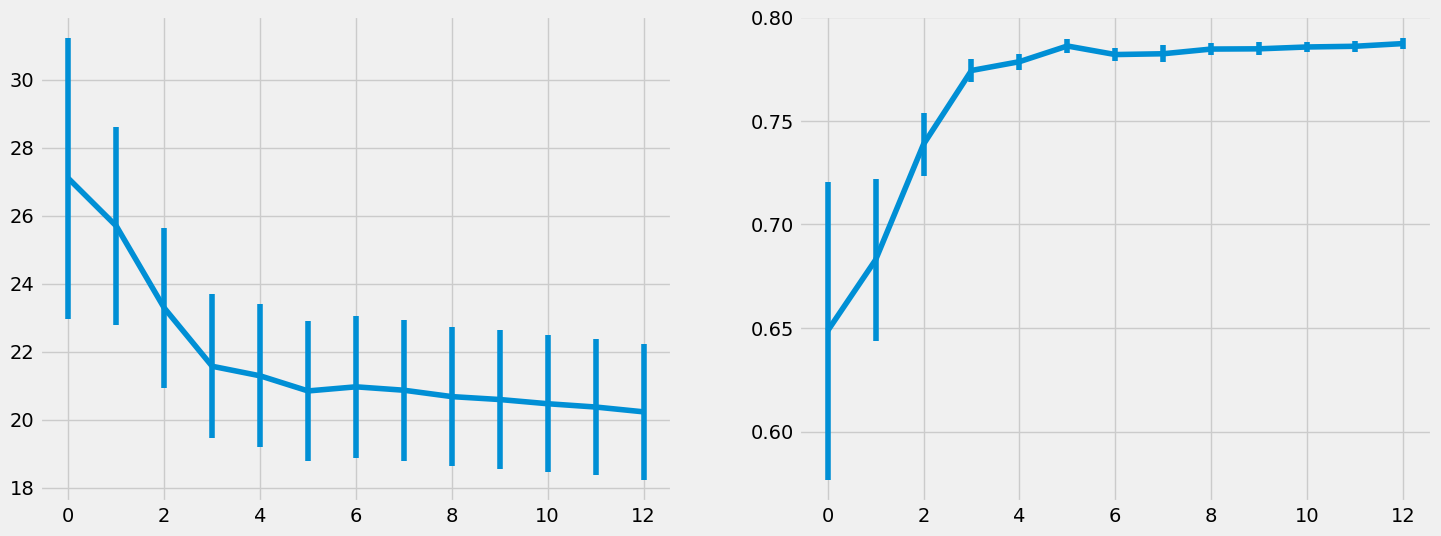

In [ ]:
# plot
fig, axs = plt.subplots(1, 2, figsize=(16,6))
#ax_rmse.set_title('')
#ax_rmse.set_xlabel("lag number")
#ax_rmse.set_ylabel("fraction of houses selecting this lag by RFECV")
#ax_r2.set_ylabel("av. PACF value across houses")
p1 = axs[0].errorbar(
            np.arange(len(sorted_lags)+1), 
            np.mean(all_rmses[clients_subset, :], axis=0), 
            np.std(all_rmses[clients_subset, :], axis=0))#label="RFECV score", c='b')
p2 = axs[1].errorbar(np.arange(len(sorted_lags)+1), 
            np.mean(all_adjr2s[clients_subset, :], axis=0), 
            np.std(all_adjr2s[clients_subset, :], axis=0))
#ax_rmse.legend(labelcolor="linecolor")
#ax_rmse.yaxis.get_label().set_color(p1.get_color())
#ax_r2.yaxis.get_label().set_color(p2.get_color())

In [ ]:
num_lags_opt_r2 = np.argmax(np.mean(all_adjr2s[clients_subset, :], axis=0))
print(num_lags_opt_r2)
mean_rmse = np.mean(all_rmses[clients_subset, :], axis=0)
min_rmse = np.min(mean_rmse)
num_lags_opt_rmse = list(mean_rmse<min_rmse*1.05).index(True)
print(num_lags_opt_rmse)

for num_lags_opt, met in zip([num_lags_opt_r2, num_lags_opt_rmse], ['r2', 'rmse']):
    selected_lags=sorted_lags[0:num_lags_opt]
    #selected_lag_nums = [int(x.split()[-1]) for x in selected_lags]
    #selected_lag_nums.sort()
    #print(selected_lag_nums)
    print('[INFO] the following {:2.0f} lags were selected using '.format(num_lags_opt) + met + ' criterion: ', selected_lags)

12
5
[INFO] the following 12 lags were selected using r2 criterion:  ['lag 1', 'lag 2', 'lag 3', 'lag 19', 'lag 4', 'lag 23', 'lag 42', 'lag 40', 'lag 30', 'lag 29', 'lag 672', 'lag 671']
[INFO] the following  5 lags were selected using rmse criterion:  ['lag 1', 'lag 2', 'lag 3', 'lag 19', 'lag 4']


In [ ]:


# divide
#lag_rfecv = np.array([int(x.replace('lag ','')) for x in feat_rfecv if x.startswith('lag ')])
#feat_col_rfecv = [x for x in feat_rfecv if not x.startswith('lag ') and not x=='constant']
'''
# fit Ridge with selected features
for client_num in clients_subset:
    house = houses[client_num]
    house.feature_names = feat_rfecv
    # construct regression matrices
    data_tuple = house.construct_regression_matrices(
                            m_train=scenario['m_train'],
                            train_years=scenario['train_years'],
                            exclude_last_year=scenario['exclude_last_year'])

    # remove constant lags
    house.data_power, data_tuple, house.feature_names = remove_constant_cols(
                            data_power=house.data_power, 
                            data_tuple=data_tuple, 
                            feature_names=house.feature_names)

    # fit Ridge regression with Grid search over penalty
    best_model, best_res = best_lin_reg(
        clients_data=[data_tuple], 
        client_num_fix=0, # because only data of 1 client 
        logger=None, 
        criterion='rmse', 
        normalize_data=True, 
        verbose=True)
        '''

# Feature Selection Based on Several Houses

In [ ]:
for client_num in clients_subset:
    lag_rfecv, feat_col_rfecv = rfecv_selection(
                    house=houses[client_num], max_num_days=1, keep_non_ar=True,
                    step_ahead=1, repeats=3, verbose=False, plot_fig=True)
    print('[RES] : ', *lag_rfecv)
    print('[RES] : ', *feat_col_rfecv)



In [ ]:
selected_lags=[1,18, 19, 20, 21, 22, 23, 44, 45, 47]
env_dict.set_lags(selected_lags)
env_dict = env_dict.generate_clients_data()
for scenario_name in env_dict['train_scenarios'].keys():
    print(scenario_name + ' has {:3.0f} train and {:3.0f} validation samples'.format(
                    env_dict['train_scenarios'][scenario_name]['clients_data'][0][0].shape[0],
                    env_dict['train_scenarios'][scenario_name]['clients_data'][0][2].shape[0]))
print('number of features = {:2.0f}'.format(
                    env_dict['train_scenarios'][scenario_name]['clients_data'][0][0].shape[1]))

save_env = True
if save_env:
    # save env
    file = open(filename_env, 'wb')
    pickle.dump(env_dict, file)
    msg = '[INFO] saved data for {:2.0f} clients'.format(env_dict['num_clients'])

# Part 2: Feature Engineering
Weather station direct and diffuse irradiation added to features of all houses
* Irradiation measured at a weather station not at each house => economically feasible
* Effect of including irradiation from weather station
* Do lags add more information?
    ** fit a linear model to 5 years of data, compare accuracies
* Using irradiation at t to predict power at t+1 vs. "predicted" irradiation at t+1 to predict power at t+1
    ** removing the need to another prediction model for the irradiation


### Results:
---------- LINEAR AND RIDGE REGRESSION WITHOUT GP ---------- <br>
sml<br>
with lags mean validation RMSE: 12.91 +/- 12.27<br>
no lags mean validation RMSE: 20.64 +/- 19.00<br>
no irradiation mean validation RMSE: 13.72 +/- 12.96<br>
delayed irradiation mean validation RMSE: 13.02 +/- 12.39<br>
1y<br>
with lags mean validation RMSE: 11.55 +/- 11.19<br>
no lags mean validation RMSE: 20.50 +/- 18.88<br>
no irradiation mean validation RMSE: 12.69 +/- 12.00<br>
delayed irradiation mean validation RMSE: 11.57 +/- 11.22<br>
5y<br>
with lags mean validation RMSE: 11.47 +/- 11.27<br>
no lags mean validation RMSE: 20.43 +/- 18.93<br>
no irradiation mean validation RMSE: 12.28 +/- 11.88<br>
delayed irradiation mean validation RMSE: 11.50 +/- 11.30<br>
15y<br>
with lags mean validation RMSE: 11.48 +/- 11.28<br>
no lags mean validation RMSE: 20.43 +/- 18.93<br>
no irradiation mean validation RMSE: 12.23 +/- 11.70<br>
delayed irradiation mean validation RMSE: 11.50 +/- 11.32<br>

In [ ]:
run_cell = False
if run_cell:
    from model_training.search_models import best_lin_reg
    normalize_data=True
    verbose=False

    num_clients=24
    city_names = ['Lausanne']
    env_dict_with_lags = {'city_names':city_names,
                'num_clients': num_clients, 'num_modes': len(city_names),
                'tilt_std': 5, 'az_std':15, 'weather_dev':0.1,
                'irrad_std':0.2, 'altitude_dev':0.1, 'shadow_peak_red':0.6,
                'module_name': get_available_modules('sandia')[0:num_clients],
                'inverter_name': get_available_inverters('cec')[0:num_clients],
                'lags':None, 'months':[3,4], 'hours':np.arange(7, 17), 
                'years':np.arange(2014, 2020), # 5 years of data
                'use_station_irrad_direct':True, 'use_station_irrad_diffuse':True,
                'delay_irrad':False, # this env uses predicted irrad
                'train_scenarios':{'sml':{'m_train':50, 'train_years':[2018], 'exclude_last_year':True},
                                '1y':{'m_train':None, 'train_years':[2018], 'exclude_last_year':True},
                                '5y':{'m_train':None, 'train_years':np.arange(2014, 2019), 'exclude_last_year':True},
                                '15y':{'m_train':None, 'train_years':None, 'exclude_last_year':True}}}
    env_dict_with_lags = PVDataset(env_dict_with_lags).generate_clients_data()

    env_dict_no_lags = copy.deepcopy(env_dict_with_lags)
    env_dict_no_irrad = copy.deepcopy(env_dict_with_lags)
    env_dict_delayed = copy.deepcopy(env_dict_with_lags)

    # features to keep 
    inds_to_keep_no_lags, inds_to_keep_no_irrad = [], []
    for ind, feature_name in enumerate(env_dict_with_lags['feature_names']):
        if not feature_name.startswith('lag'):
            inds_to_keep_no_lags.append(ind)
        if not feature_name.startswith('station_irrad'):
            inds_to_keep_no_irrad.append(ind)
    # features to delay for delayed irrads
    cols_to_delay=[]
    for ind, feature_name in enumerate(env_dict_delayed['feature_names']):
        if feature_name.startswith('station_irrad'):
            cols_to_delay.append(ind)

    # only keep the selected features
    for client_num in np.arange(env_dict_with_lags['num_clients']):
        for scenario in env_dict_with_lags['train_scenarios']:
            x_train, y_train, x_valid, y_valid = env_dict_with_lags['train_scenarios'][scenario]['clients_data'][client_num]
            # no lags
            x_train_no_lags = x_train[:, inds_to_keep_no_lags]
            x_valid_no_lags = x_valid[:, inds_to_keep_no_lags]
            env_dict_no_lags['train_scenarios'][scenario]['clients_data'][client_num] = (x_train_no_lags, y_train, x_valid_no_lags, y_valid)
            # no irrad
            x_train_no_irrad = x_train[:, inds_to_keep_no_irrad]
            x_valid_no_irrad = x_valid[:, inds_to_keep_no_irrad]
            env_dict_no_irrad['train_scenarios'][scenario]['clients_data'][client_num] = (x_train_no_irrad, y_train, x_valid_no_irrad, y_valid)
            # delayed irrad
            # NOTE: one less sample
            x_train_dalayed, y_train_dalayed = x_train[1:, :], y_train[1:]
            x_valid_dalayed, y_valid_dalayed = x_valid[1:, :], y_valid[1:]
            x_train_dalayed[:, cols_to_delay] = x_train[:-1, cols_to_delay]
            x_valid_dalayed[:, cols_to_delay] = x_valid[:-1, cols_to_delay]
            env_dict_delayed['train_scenarios'][scenario]['clients_data'][client_num] = (x_train_dalayed, y_train_dalayed, 
                                                            x_valid_dalayed, y_valid_dalayed)


    env_dict_no_lags['feature_names'] = [x for i, x in enumerate(env_dict_no_lags['feature_names']) if i in inds_to_keep_no_lags]
    env_dict_no_irrad['feature_names'] = [x for i, x in enumerate(env_dict_no_irrad['feature_names']) if i in inds_to_keep_no_irrad]



    print('\n---------- LINEAR AND RIDGE REGRESSION ----------')
    env_names = ['with lags', 'no lags', 'no irradiation', 'delayed irradiation']
    envs = [env_dict_with_lags, env_dict_no_lags, env_dict_no_irrad, env_dict_delayed]
    for scenario_name in env_dict_with_lags['train_scenarios'].keys():
        print(scenario_name)
        for env_tmp, env_name in zip(envs, env_names):
            # Linear regression without GP
            valid_rmses_linreg = np.zeros(num_clients)
            for client_num in np.arange(num_clients):
                if verbose:
                    print('\nClient {:2.0f}'.format(client_num))
                _, valid_rmses_linreg[client_num] = best_lin_reg(clients_data=env_tmp['train_scenarios'][scenario_name]['clients_data'], 
                            client_num=client_num, logger=None, normalize_data=normalize_data, verbose=verbose) 

            print(env_name + ' mean validation RMSE: {:2.2f} +/- {:.2f}'.format(np.mean(valid_rmses_linreg),
                                                                    1.96*np.std(valid_rmses_linreg)))


## 2.2 Checking modelling assumptions
* multicollinearity
* is data from each house homogeneous and i.i.d?
* are houses independent?

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

for train_scenario in env_dict['train_scenarios'].keys():
    print('\n Train scenario: ', train_scenario)
    # VIF dataframe
    vif_data = pd.DataFrame()
    vif_data["feature"] = env_dict['feature_names']
    for client_num in np.arange(num_clients):
        # get train data
        X_train = env_dict['train_scenarios'][train_scenario]['clients_data'][client_num][0]

        # calculating VIF for each feature
        vif_data[str(client_num)] = [variance_inflation_factor(X_train, i)
                                for i in range(len(env_dict['feature_names']))]

    vif_data["average"] = vif_data.mean(axis=1)
    print(vif_data)


# save env

# Notes:
To use the generated data, first load the saved env by running


file = open(filename_env, 'rb')
env_dict = pickle.load(file)
msg = '[INFO] loaded data for {:2.0f} clients'.format(env_dict['num_clients'])

* To experiment with the data-rich scenario, use 
clients_data = env_dict['train_scenarios']['5y']['clients_data']
* To experiment with the data-scarce scenario, use 
clients_data = env_dict['train_scenarios']['sml']['clients_data']


In both cases, "clients_data" is a list of length "num_clients".

For a client with number "client_num", clients_data[client_num] is a tuple of length 4, where:

x_train, y_train, x_valid, y_valid = clients_data[client_num]